
# Visualizing discrete-continuous convolutions
Visualizing the behavior of DISCO convolutions, the building block of the localized neural operator framework.

These modules can be used on both equidistant and unstructured grids.


Preparation



In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import math
from functools import partial

from matplotlib import image

from torch_harmonics.quadrature import legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights

import matplotlib.pyplot as plt

cmap="inferno"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from neuralop.layers.discrete_continuous_convolution import DiscreteContinuousConv2d, DiscreteContinuousConvTranspose2d, EquidistantDiscreteContinuousConv2d, EquidistantDiscreteContinuousConvTranspose2d

Let's start by loading an example image



C:\Users\alfre\AppData\Local\Temp\ipykernel_27068\1807986515.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze()


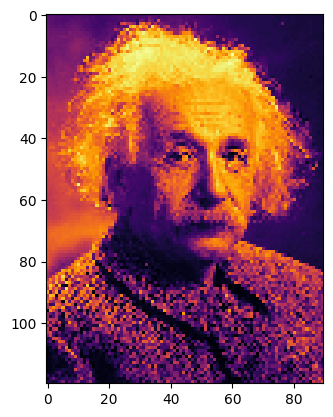

In [2]:
os.system("curl https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Albert_Einstein_Head.jpg/360px-Albert_Einstein_Head.jpg -o ./einstein.jpg")

nx = 90
ny = 120

img = image.imread('./einstein.jpg')
data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze()
plt.imshow(data, cmap=cmap)
plt.show()

Let's create a grid on which the data lives



In [3]:
x_in = torch.linspace(0, 2, nx)
y_in = torch.linspace(0, 3, ny)

x_in, y_in = torch.meshgrid(x_in, y_in)
grid_in = torch.stack([x_in.reshape(-1), y_in.reshape(-1)])

# compute the correct quadrature weights
# IMPORTANT: this needs to be done right in order for the DISCO convolution to be normalized proeperly
w_x = 2*torch.ones_like(x_in) / nx
w_y = 3*torch.ones_like(y_in) / ny
q_in = (w_x * w_y).reshape(-1)

c:\Users\alfre\OneDrive\Documentos\Universidad\9NO SEMESTRE\EDPN\Proyecto_FNO\fno_venv\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Visualize the grid



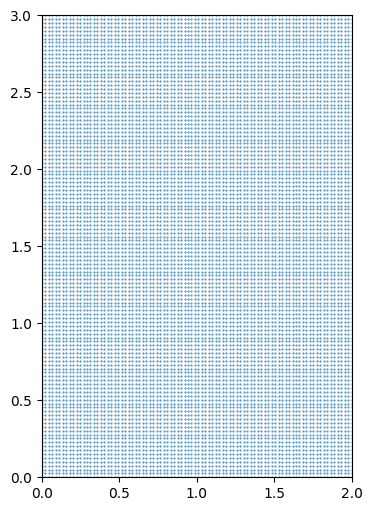

In [4]:
plt.figure(figsize=(4,6), )
plt.scatter(grid_in[0], grid_in[1], s=0.2)
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

Format data into the same format and plot it on the grid



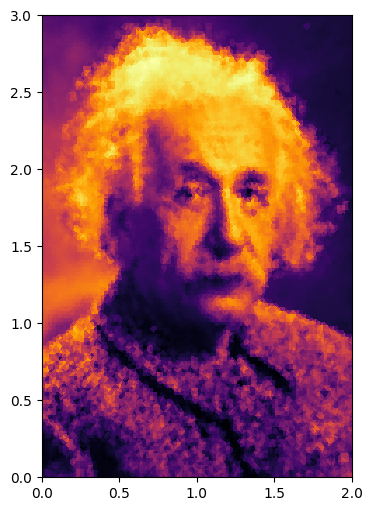

In [5]:
data = data.permute(1,0).flip(1).reshape(-1)

plt.figure(figsize=(4,6), )
plt.tripcolor(grid_in[0], grid_in[1], data, cmap=cmap)
# plt.colorbar()
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

For the convolution output we require an output mesh



In [6]:
nxo = 90
nyo = 120

x_out = torch.linspace(0, 2, nxo)
y_out = torch.linspace(0, 3, nyo)

x_out, y_out = torch.meshgrid(x_out, y_out)
grid_out = torch.stack([x_out.reshape(-1), y_out.reshape(-1)])

# compute the correct quadrature weights
w_x = 2*torch.ones_like(x_out) / nxo
w_y = 3*torch.ones_like(y_out) / nyo
q_out = (w_x * w_y).reshape(-1)

Initialize the convolution and set the weights to something resembling an edge filter/finit differences



In [7]:
conv = DiscreteContinuousConv2d(1, 1, grid_in=grid_in, grid_out=grid_out, quadrature_weights=q_in, kernel_shape=[2,4], radius_cutoff=5/nyo, periodic=False).float()

# initialize a kernel resembling an edge filter
w = torch.zeros_like(conv.weight)
w[0,0,1] = 1.0
w[0,0,3] = -1.0
conv.weight = nn.Parameter(w)
psi = conv.get_local_filter_matrix()

in order to compute the convolved image, we need to first bring it into the right shape with `batch_size x n_channels x n_grid_points`



torch.Size([1, 1, 10800])


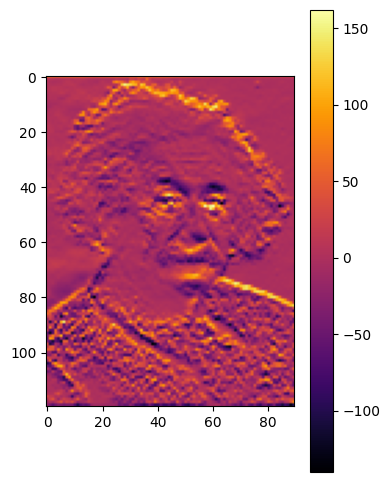

In [8]:
out = conv(data.reshape(1, 1, -1))

print(out.shape)

plt.figure(figsize=(4,6), )
plt.imshow(torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()
plt.show()

out1 = torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0,1), dims=(-2, ))

torch.Size([1, 1, 119, 89])


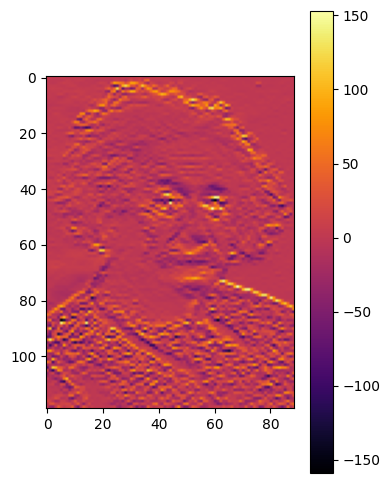

torch.Size([119, 89])


In [10]:
conv_equi = EquidistantDiscreteContinuousConv2d(1, 1, (nx, ny), (nxo, nyo), kernel_shape=[2,4], radius_cutoff=5/nyo, domain_length=[2,3])

# initialize a kernel resembling an edge filter
w = torch.zeros_like(conv.weight)
w[0,0,1] = 1.0
w[0,0,3] = -1.0
conv_equi.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).float()

out_equi = conv_equi(data)

print(out_equi.shape)

plt.figure(figsize=(4,6), )
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()

out2 = out_equi.squeeze().detach()

print(out2.shape)

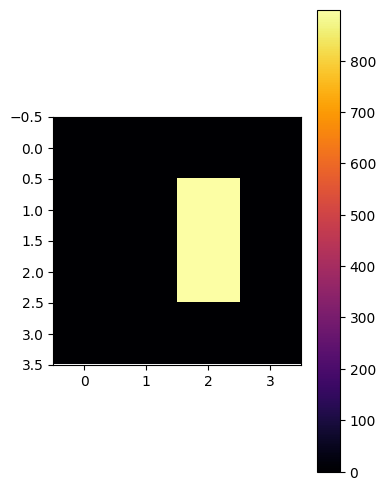

In [11]:
plt.figure(figsize=(4,6), )
plt.imshow(conv_equi.get_local_filter_matrix()[0].detach(), cmap=cmap)
plt.colorbar()

# # %%

# print("plt the error:")
# plt.figure(figsize=(4,6), )
# plt.imshow(out1 - out2, cmap=cmap)
# plt.colorbar()
# plt.show()

torch.Size([1, 1, 10800])


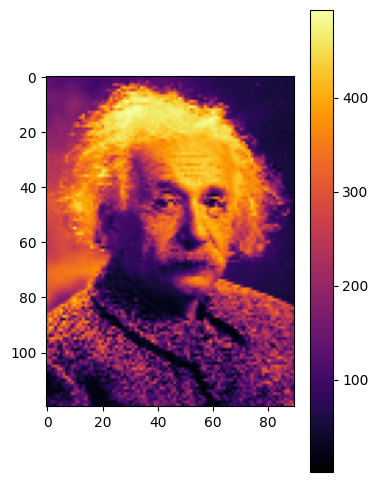

In [12]:
convt = DiscreteContinuousConvTranspose2d(1, 1, grid_in=grid_out, grid_out=grid_in, quadrature_weights=q_out, kernel_shape=[2,4], radius_cutoff=3/nyo, periodic=False).float()

# initialize a flat
w = torch.zeros_like(conv.weight)
w[0,0,0] = 1.0
w[0,0,1] = 1.0
w[0,0,2] = 1.0
w[0,0,3] = 1.0
convt.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze().float().permute(1,0).flip(1).reshape(-1)
out = convt(data.reshape(1, 1, -1))

print(out.shape)

plt.figure(figsize=(4,6), )
plt.imshow(torch.flip(out.squeeze().detach().reshape(nx, ny).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()
plt.show()

torch.Size([1, 1, 120, 90])


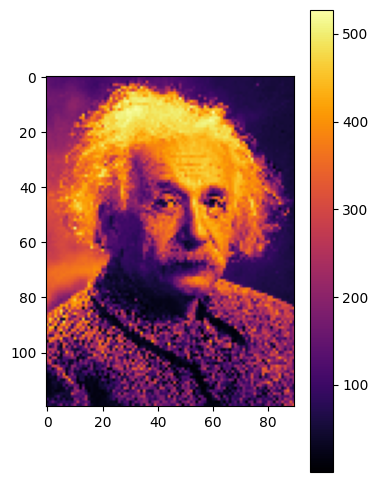

In [13]:
convt_equi = EquidistantDiscreteContinuousConvTranspose2d(1, 1, (nxo, nyo), (nx, ny), kernel_shape=[2,4], radius_cutoff=3/nyo, domain_length=[2,3])

# initialize a flat
w = torch.zeros_like(convt_equi.weight)
w[0,0,0] = 1.0
w[0,0,1] = 1.0
w[0,0,2] = 1.0
w[0,0,3] = 1.0
convt_equi.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(nyo,nxo)).float()
out_equi = convt_equi(data)

print(out_equi.shape)

plt.figure(figsize=(4,6), )
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()